In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np 
import pandas as pd
import os

print(torch.__version__)

1.5.0


In [2]:
os.chdir("/home/diego/Escritorio")

In [3]:
data=pd.read_csv("chen.csv")

In [4]:
u=data.values[:,0]
d=data.values[:,1]

In [5]:
cantidad_datos=6000
cantidad_train=int(0.55*cantidad_datos)
cantidad_test=int(0.25*cantidad_datos)
cantidad_val=int(0.2*cantidad_datos)

Text(0.5, 1.0, 'Salida ante excitación persistente')

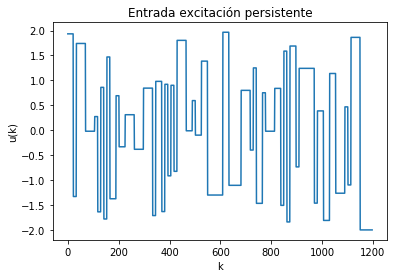

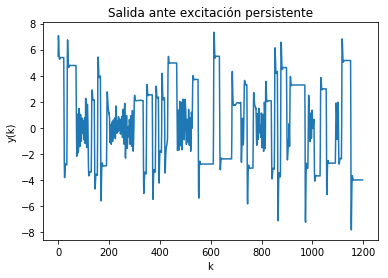

In [6]:
u_train=u[0:cantidad_train]
d_train=d[0:cantidad_train]
u_test=u[cantidad_train+1:cantidad_train+cantidad_test]
d_test=d[cantidad_train+1:cantidad_train+cantidad_test]
u_val=u[cantidad_train+cantidad_test+1:cantidad_train+cantidad_test+cantidad_val]
d_val=d[cantidad_train+cantidad_test+1:cantidad_train+cantidad_test+cantidad_val]

plt.figure()
plt.plot(u_val)
plt.xlabel('k')
plt.ylabel('u(k)')
plt.title('Entrada excitación persistente')


plt.figure()
plt.plot(d_val)
plt.xlabel('k')
plt.ylabel('y(k)')
plt.title('Salida ante excitación persistente')




In [7]:
y_min = min(d_train)
y_max = max(d_train)
u_min = min(u_train)
u_max = max(u_train)

#Noramalizar los datos
for i in range(len(d_train)):
    d_train[i]=(d_train[i]-y_min)/(y_max-y_min)
    u_train[i]=(u_train[i]-u_min)/(u_max-u_min)

#Construir regresores
u_train_1=u_train[1:-2] #u(k-1)
d_train_1=d_train[1:-2] #d(k-1)
u_train_2=u_train[0:-3] #u(k-2)
d_train_2=d_train[0:-3] #d(k-2)
d_train_0=d_train[2:-1] #d(k)

data_train=np.array([d_train_1, d_train_2, u_train_1, u_train_2])

In [8]:
#Dar forma correcta de entrada a la red
data_train=np.reshape(data_train,(4,-1))
data_train=np.transpose(data_train)
d_train_0=np.array([d_train_0])
d_train_0=np.reshape(d_train_0,(-1,1))

In [9]:
#Clase de construccion de la red
class MLP(nn.Module):
    def __init__(self,neural_layers,act_fun):
        super(MLP, self).__init__()
        self.layers = nn.Sequential()
        
        if len(neural_layers) < 2:
          print('len(neural_layes) must be higher than 2')
          return
        for i in range(len(neural_layers)-1):
          self.layers.add_module('layer_{}'.format(i+1),
                                 nn.Linear(neural_layers[i],
                                           neural_layers[i+1])
                                 )
          self.layers.add_module('act_fun_{}'.format(i+1),
                                 act_fun[i])
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [10]:
#Clase muy sencilla para dar de entrada al data loader
class neural_Dataset(Dataset):
  def __init__(self,X,y):
    if X.shape[0] != y.shape[0]:
      #print('First dimesion of X and y must be the same')
      return
      
    self.X = X
    self.y = y
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self,idx):
    Xi = self.X[idx]
    yi = self.y[idx]
    return Xi,yi

In [11]:
batch_size = 500
epochs = 1000
dataset = neural_Dataset(data_train,d_train_0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)
lamb=500/batch_size

net = MLP([4, 10, 3],[nn.Tanh(), nn.Identity()])
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
mse=nn.MSELoss()
relu=nn.ReLU()

net.train
for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(dataloader):
    optimizer.zero_grad()
    output = net(data.float())
    
    salida1=torch.reshape(output[:,0],(-1,1))
    salida2=torch.reshape(output[:,1],(-1,1))
    salida3=torch.reshape(output[:,2],(-1,1))
    
    
    L_upper = mse(salida1,target.float())+lamb*sum(relu(salida1-target.float())*relu(salida1-target.float()))
    L_crisp = mse(salida2,target.float())
    L_lower = mse(salida3,target.float())+lamb*sum(relu(-salida3+target.float())*relu(-salida3+target.float()))
    
    L_upper.backward(retain_graph=True)
    L_crisp.backward(retain_graph=True)
    L_lower.backward(retain_graph=True)
    
    optimizer.step()
  print('Epoch : {} || Loss (lower, crisp and upper) : {:.3f}'.format(epoch+1,L_lower.item())+' '+'{:.3f}'.format(L_crisp.item())+' '+'{:.3f}'.format(L_upper.item()))

Epoch : 1 || Loss (lower, crisp and upper) : 20.131 0.676 0.199
Epoch : 2 || Loss (lower, crisp and upper) : 19.171 0.671 0.197
Epoch : 3 || Loss (lower, crisp and upper) : 18.242 0.666 0.194
Epoch : 4 || Loss (lower, crisp and upper) : 17.346 0.662 0.192
Epoch : 5 || Loss (lower, crisp and upper) : 16.485 0.657 0.190
Epoch : 6 || Loss (lower, crisp and upper) : 15.659 0.652 0.187
Epoch : 7 || Loss (lower, crisp and upper) : 14.867 0.648 0.185
Epoch : 8 || Loss (lower, crisp and upper) : 14.109 0.643 0.183
Epoch : 9 || Loss (lower, crisp and upper) : 13.384 0.638 0.180
Epoch : 10 || Loss (lower, crisp and upper) : 12.693 0.633 0.178
Epoch : 11 || Loss (lower, crisp and upper) : 12.033 0.629 0.176
Epoch : 12 || Loss (lower, crisp and upper) : 11.404 0.624 0.174
Epoch : 13 || Loss (lower, crisp and upper) : 10.804 0.620 0.171
Epoch : 14 || Loss (lower, crisp and upper) : 10.233 0.615 0.169
Epoch : 15 || Loss (lower, crisp and upper) : 9.690 0.610 0.167
Epoch : 16 || Loss (lower, crisp an

Epoch : 129 || Loss (lower, crisp and upper) : 0.140 0.217 0.046
Epoch : 130 || Loss (lower, crisp and upper) : 0.138 0.214 0.046
Epoch : 131 || Loss (lower, crisp and upper) : 0.136 0.212 0.046
Epoch : 132 || Loss (lower, crisp and upper) : 0.135 0.210 0.046
Epoch : 133 || Loss (lower, crisp and upper) : 0.133 0.208 0.045
Epoch : 134 || Loss (lower, crisp and upper) : 0.131 0.206 0.045
Epoch : 135 || Loss (lower, crisp and upper) : 0.130 0.204 0.045
Epoch : 136 || Loss (lower, crisp and upper) : 0.128 0.202 0.045
Epoch : 137 || Loss (lower, crisp and upper) : 0.127 0.200 0.044
Epoch : 138 || Loss (lower, crisp and upper) : 0.125 0.198 0.044
Epoch : 139 || Loss (lower, crisp and upper) : 0.124 0.196 0.044
Epoch : 140 || Loss (lower, crisp and upper) : 0.122 0.194 0.044
Epoch : 141 || Loss (lower, crisp and upper) : 0.121 0.192 0.044
Epoch : 142 || Loss (lower, crisp and upper) : 0.120 0.190 0.043
Epoch : 143 || Loss (lower, crisp and upper) : 0.118 0.189 0.043
Epoch : 144 || Loss (lowe

Epoch : 257 || Loss (lower, crisp and upper) : 0.046 0.066 0.029
Epoch : 258 || Loss (lower, crisp and upper) : 0.045 0.065 0.029
Epoch : 259 || Loss (lower, crisp and upper) : 0.045 0.065 0.029
Epoch : 260 || Loss (lower, crisp and upper) : 0.045 0.064 0.029
Epoch : 261 || Loss (lower, crisp and upper) : 0.045 0.064 0.029
Epoch : 262 || Loss (lower, crisp and upper) : 0.045 0.063 0.029
Epoch : 263 || Loss (lower, crisp and upper) : 0.045 0.063 0.029
Epoch : 264 || Loss (lower, crisp and upper) : 0.044 0.062 0.029
Epoch : 265 || Loss (lower, crisp and upper) : 0.044 0.062 0.029
Epoch : 266 || Loss (lower, crisp and upper) : 0.044 0.061 0.029
Epoch : 267 || Loss (lower, crisp and upper) : 0.044 0.061 0.029
Epoch : 268 || Loss (lower, crisp and upper) : 0.044 0.061 0.029
Epoch : 269 || Loss (lower, crisp and upper) : 0.044 0.060 0.028
Epoch : 270 || Loss (lower, crisp and upper) : 0.043 0.060 0.028
Epoch : 271 || Loss (lower, crisp and upper) : 0.043 0.059 0.028
Epoch : 272 || Loss (lowe

Epoch : 384 || Loss (lower, crisp and upper) : 0.040 0.033 0.024
Epoch : 385 || Loss (lower, crisp and upper) : 0.040 0.033 0.024
Epoch : 386 || Loss (lower, crisp and upper) : 0.040 0.033 0.024
Epoch : 387 || Loss (lower, crisp and upper) : 0.040 0.033 0.024
Epoch : 388 || Loss (lower, crisp and upper) : 0.040 0.033 0.024
Epoch : 389 || Loss (lower, crisp and upper) : 0.040 0.033 0.024
Epoch : 390 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 391 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 392 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 393 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 394 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 395 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 396 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 397 || Loss (lower, crisp and upper) : 0.040 0.032 0.024
Epoch : 398 || Loss (lower, crisp and upper) : 0.040 0.031 0.024
Epoch : 399 || Loss (lowe

Epoch : 511 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 512 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 513 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 514 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 515 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 516 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 517 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 518 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 519 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 520 || Loss (lower, crisp and upper) : 0.043 0.022 0.022
Epoch : 521 || Loss (lower, crisp and upper) : 0.043 0.021 0.022
Epoch : 522 || Loss (lower, crisp and upper) : 0.043 0.021 0.022
Epoch : 523 || Loss (lower, crisp and upper) : 0.043 0.021 0.022
Epoch : 524 || Loss (lower, crisp and upper) : 0.044 0.021 0.022
Epoch : 525 || Loss (lower, crisp and upper) : 0.044 0.021 0.022
Epoch : 526 || Loss (lowe

Epoch : 639 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 640 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 641 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 642 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 643 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 644 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 645 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 646 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 647 || Loss (lower, crisp and upper) : 0.044 0.015 0.021
Epoch : 648 || Loss (lower, crisp and upper) : 0.044 0.014 0.021
Epoch : 649 || Loss (lower, crisp and upper) : 0.044 0.014 0.021
Epoch : 650 || Loss (lower, crisp and upper) : 0.044 0.014 0.021
Epoch : 651 || Loss (lower, crisp and upper) : 0.044 0.014 0.021
Epoch : 652 || Loss (lower, crisp and upper) : 0.044 0.014 0.021
Epoch : 653 || Loss (lower, crisp and upper) : 0.044 0.014 0.021
Epoch : 654 || Loss (lowe

Epoch : 766 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 767 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 768 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 769 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 770 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 771 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 772 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 773 || Loss (lower, crisp and upper) : 0.041 0.010 0.021
Epoch : 774 || Loss (lower, crisp and upper) : 0.041 0.009 0.021
Epoch : 775 || Loss (lower, crisp and upper) : 0.041 0.009 0.021
Epoch : 776 || Loss (lower, crisp and upper) : 0.041 0.009 0.021
Epoch : 777 || Loss (lower, crisp and upper) : 0.040 0.009 0.021
Epoch : 778 || Loss (lower, crisp and upper) : 0.040 0.009 0.021
Epoch : 779 || Loss (lower, crisp and upper) : 0.040 0.009 0.021
Epoch : 780 || Loss (lower, crisp and upper) : 0.040 0.009 0.021
Epoch : 781 || Loss (lowe

Epoch : 894 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 895 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 896 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 897 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 898 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 899 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 900 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 901 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 902 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 903 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 904 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 905 || Loss (lower, crisp and upper) : 0.035 0.006 0.020
Epoch : 906 || Loss (lower, crisp and upper) : 0.034 0.006 0.020
Epoch : 907 || Loss (lower, crisp and upper) : 0.034 0.006 0.020
Epoch : 908 || Loss (lower, crisp and upper) : 0.034 0.006 0.020
Epoch : 909 || Loss (lowe

In [12]:
#Armar data de validacion de entrada a la red y normalizarla
y_min = min(d_val)
y_max = max(d_val)
u_min = min(u_val)
u_max = max(u_val)

d_val_norm=np.array([d_val])
u_val_norm=np.array([u_val])

for i in range(len(d_val_norm)):
    d_val_norm[i]=(d_val_norm[i]-y_min)/(y_max-y_min)
    u_val_norm[i]=(u_val_norm[i]-u_min)/(u_max-u_min)
    
d_val_norm=d_val_norm[0]
u_val_norm=u_val_norm[0]

u_val_1=u_val_norm[1:-2] #u(k-1)
d_val_1=d_val_norm[1:-2] #d(k-1)
u_val_2=u_val_norm[0:-3] #u(k-2)
d_val_2=d_val_norm[0:-3] #d(k-2)
d_val_0=d_val_norm[2:-1] #d(k)

data_val=np.array([d_val_1, d_val_2, u_val_1, u_val_2])
data_val=np.reshape(data_val,(4,-1))
data_val=np.transpose(data_val)
d_val_0=np.array([d_val_0])
d_val_0=np.reshape(d_val_0,(-1,1))


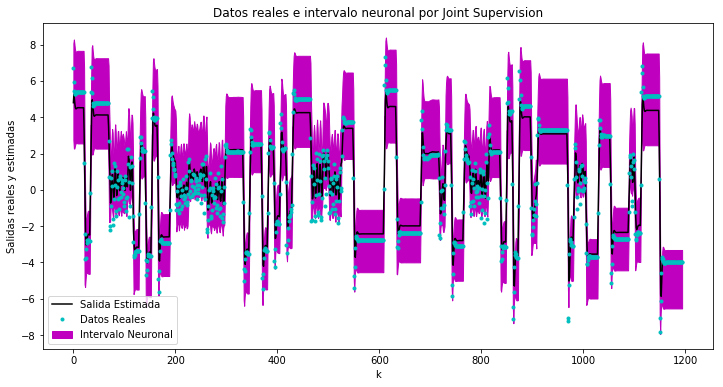

In [25]:
output=net(torch.FloatTensor(data_val)) #evaluar la salida de la red
predic_output=output.detach().numpy()
upper_out=predic_output[:,2]
crisp_out=predic_output[:,1]
lower_out=predic_output[:,0]
pasos=1 #modificar para predecir a mas o menos pasos
data_mutable=np.array([data_val]) #hacer una copia sin que se modifique la original (ojo que a priori son punteros)
data_mutable=data_mutable[0]


#calcular prediccion a pasos
if(pasos!=1):
    for i in range(2,pasos):
        data_mutable[:,1]=data_mutable[:,0]
        data_mutable[:,0]=crisp_out
        
        output=net(torch.FloatTensor(data_mutable)) #evaluar la salida de la red
        predic_output=output.detach().numpy()
        upper_out=predic_output[:,2]
        crisp_out=predic_output[:,1]
        lower_out=predic_output[:,0]


#desnormalizar la salida de la red
for i in range(len(upper_out)):
    upper_out[i]=upper_out[i]*(y_max-y_min)+y_min
    crisp_out[i]=crisp_out[i]*(y_max-y_min)+y_min
    lower_out[i]=lower_out[i]*(y_max-y_min)+y_min
    
d_val_0=d_val[2:-1] #d(k) real

fig, (ax1) = plt.subplots(1, sharex=True,figsize=(12,6))
x=np.linspace(0,1194,1195)
#plt.grid()
#ax1.plot(upper_out,'k')
#ax1.plot(lower_out,'k')
ax1.plot(crisp_out,'k',label='Salida Estimada')
ax1.plot(d_val_0,'.',color='c',label='Datos Reales')
ax1.fill_between(x,lower_out,upper_out, color='m', label='Intervalo Neuronal')
plt.title('Datos reales e intervalo neuronal por Joint Supervision')
plt.xlabel('k')
plt.ylabel('Salidas reales y estimadas')
plt.legend()


In [26]:
#metricas de evaluacion del intervalo
PICP=0
for i in range(len(d_val_0)):
    if(lower_out[i]<=d_val_0[i] and upper_out[i]>=d_val_0[i]):
        PICP+=1
PICP=PICP/len(d_val_0)

PINAW=0
for i in range(len(d_val_0)):
        PINAW+=(upper_out[i]-lower_out[i])
R=(max(d_val_0)-min(d_val_0))
PINAW=PINAW/(R*len(d_val_0))

print('Evaluacion del intervalo')
print('PICP = {:.4f}'.format(PICP))
print('PINAW = {:.4f}'.format(PINAW))




Evaluacion del intervalo
PICP = 0.9565
PINAW = 0.2686
